This notebook fits SleepNet on simulated tiles with PSF stars and Gaussian galaxies. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import time

import torch
from torch import optim

from bliss.models import encoder
from bliss.datasets import sdss

In [2]:
import sys
sys.path.insert(0, '../sdss_galaxies/')
from sparse_field_lib import load_data

In [3]:
sys.path.insert(0, './utils/')
import source_simulator_lib
import dataset_lib
import catalog_optimizer_lib

import plotting_utils 
from which_device import device

In [4]:
torch.random.manual_seed(23424)

In [5]:
sdss_dir = '/home/runingli/astronomy/celeste/data/sdss/'
psf_file = sdss_dir + '/94/1/12/psField-000094-1-0012.fits'

catalog_file = '../sdss_galaxies/coadd_field_catalog_runjing_liu.fit'

# Load PSF

In [6]:
sdss_psf = sdss.SdssPSF(psf_file, [2])

psf = sdss_psf.psf_at_points(0, 0., 0.)

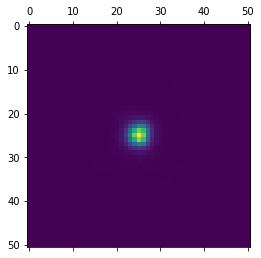

In [7]:
%matplotlib inline

plt.matshow(psf)

# The encoder

In [8]:
from bliss.sleep import SleepPhase

In [9]:
slen = 4
max_detections = 1
n_bands = 1
tile_slen = slen
ptile_slen = 52


encoder_kwargs = dict(max_detections = max_detections,
                      n_bands = 1,
                      tile_slen = tile_slen,
                      ptile_slen = ptile_slen)

# doesn't matter -- we will use our own decoder. 
# just set it up so the init works
decoder_kwargs = dict(max_sources = 2,
                      slen = slen,
                      ptile_slen = ptile_slen, 
                      tile_slen = tile_slen, 
                      psf_params_file = '../../data/fitted_powerlaw_psf_params.npy')

In [10]:
sleep_net = SleepPhase(encoder_kwargs = encoder_kwargs, 
                       decoder_kwargs = decoder_kwargs).to(device)

# The dataset

The data is sampled with PSF stars and Gaussian galaxies. 

Stars are parameterized by location and flux. 

Gaussian galaxies are parameterized by location, flux, ellipticity, rotation, and half-light radius. 

All parameters are drawn uniformly from a pre-specified range (see default arguments to `dataset_lib.SimulatedImages`). 

The probability of a star or galaxy is 50/50. 

In [11]:
background = 862

In [12]:
_psf = torch.Tensor([psf]).to(device)

In [13]:
batchsize = 256
border_padding = sleep_net.image_decoder.border_padding

simulated_dataset = dataset_lib.SimulatedImages(_psf, 
                                                slen = slen,
                                                tile_slen = tile_slen, 
                                                ptile_slen = ptile_slen, 
                                                # set so that there is always one source
                                                mean_sources_per_tile = 100,
                                                max_sources_per_tile = max_detections, 
                                                n_images = batchsize, 
                                                border_padding = border_padding, 
                                                background = background)

In [14]:
batch = simulated_dataset.sample_batch()

### print an image

In [15]:
gal_bool = batch['galaxy_bool'].squeeze()

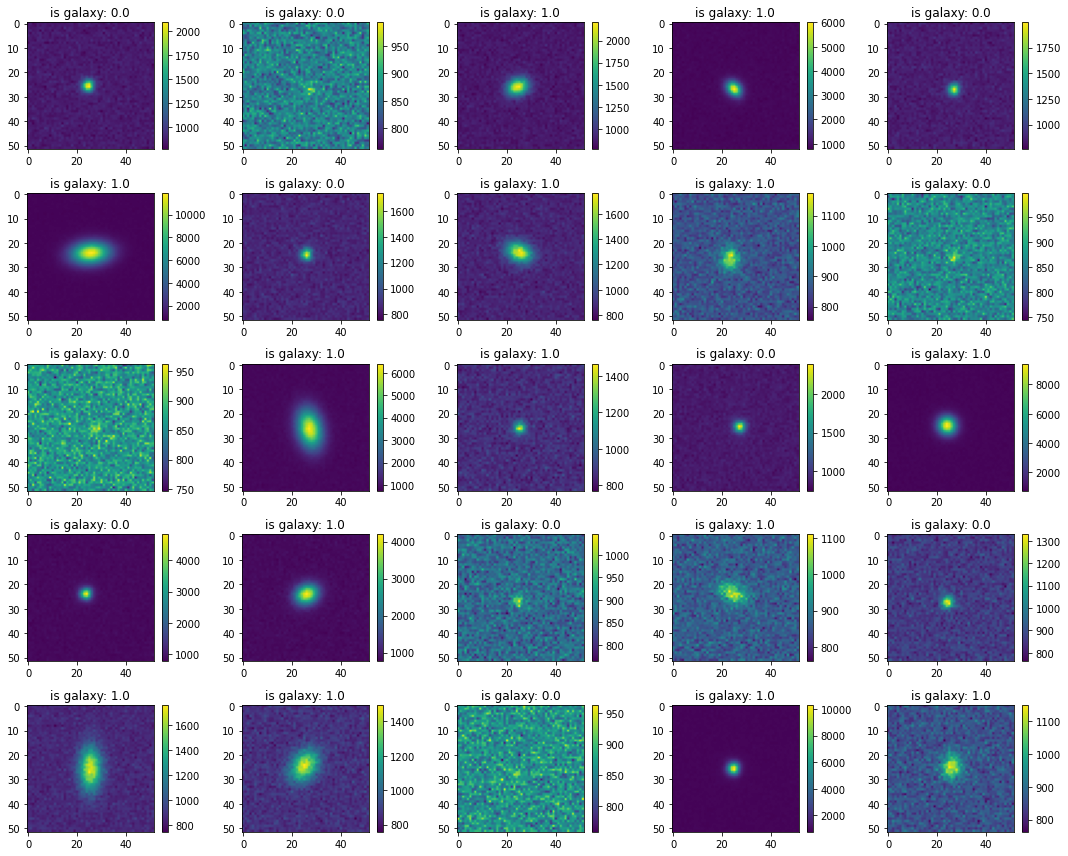

In [16]:
%matplotlib inline

fig, axes = plt.subplots(5, 5, figsize=(15,12))

for i in range(25): 
    
    this_plot = axes[i // 5, i % 5]
    
    im = this_plot.imshow(batch['images'][i, 0].cpu())
    fig.colorbar(im, ax = this_plot)
    this_plot.set_title('is galaxy: {}'.format(gal_bool[i]))
    
fig.tight_layout()

# Train

In [17]:
sleep_net.train();

In [18]:
n_iter = 600

In [19]:
learning_rate = 1e-3
weight_decay = 1e-5
optimizer = optim.Adam([
                    {'params': sleep_net.parameters(),
                    'lr': learning_rate}],
                    weight_decay = weight_decay)


In [20]:
t0 = time.time()

for i in range(n_iter + 1): 
        
    batch = simulated_dataset.sample_batch()
    
    optimizer.zero_grad()
    loss = sleep_net.get_detection_loss(batch)[0]
    
    if torch.isnan(loss): 
        break
    
    loss.backward()
    optimizer.step()

    if i % 50 == 0: 
        elapsed = time.time() - t0
        print('iter: [{}]; loss: {:0.4f}; elapsed: {:0.2f}secs'.format(i, loss, elapsed))
        t0 = time.time()
        
print('done')

iter: [0]; loss: 23.1666; elapsed: 0.18secs
iter: [50]; loss: 1.5390; elapsed: 6.60secs
iter: [100]; loss: -0.9380; elapsed: 6.61secs
iter: [150]; loss: -1.1332; elapsed: 6.60secs
iter: [200]; loss: -1.4142; elapsed: 6.60secs
iter: [250]; loss: -1.8940; elapsed: 6.61secs
iter: [300]; loss: -2.4102; elapsed: 6.64secs
iter: [350]; loss: -2.0989; elapsed: 6.64secs
iter: [400]; loss: -2.8912; elapsed: 6.64secs
iter: [450]; loss: -3.2055; elapsed: 6.65secs
iter: [500]; loss: -3.3735; elapsed: 6.68secs
iter: [550]; loss: -3.5772; elapsed: 6.67secs
iter: [600]; loss: -3.2220; elapsed: 6.67secs
done


# Evaluate

In [25]:
sleep_net.eval();

In [26]:
loss = sleep_net.get_detection_loss(batch)[0]
print(loss)

tensor(-3.3963, device='cuda:4', grad_fn=<MeanBackward0>)


### draw fresh batch

In [27]:
batch = simulated_dataset.sample_batch()

### get estimates

In [46]:
with torch.no_grad():
    tile_est = sleep_net.tile_images_map_estimate(batch['images'])
    
    # need to do something a little different to get the probability of galaxy 
    var_params = sleep_net.image_encoder(batch['images'], batch['n_sources'].squeeze())

In [47]:
true_locs = batch['locs'].squeeze().cpu()
est_locs = tile_est['locs'].squeeze().cpu()

true_gal_bool = batch['galaxy_bool'].squeeze().cpu()
est_gal_bool = tile_est['galaxy_bool'].squeeze().cpu()

In [53]:
prob_galaxy = var_params['prob_galaxy'].squeeze().cpu()

# make sure this is correct
assert torch.all((prob_galaxy > 0.5) == est_gal_bool)

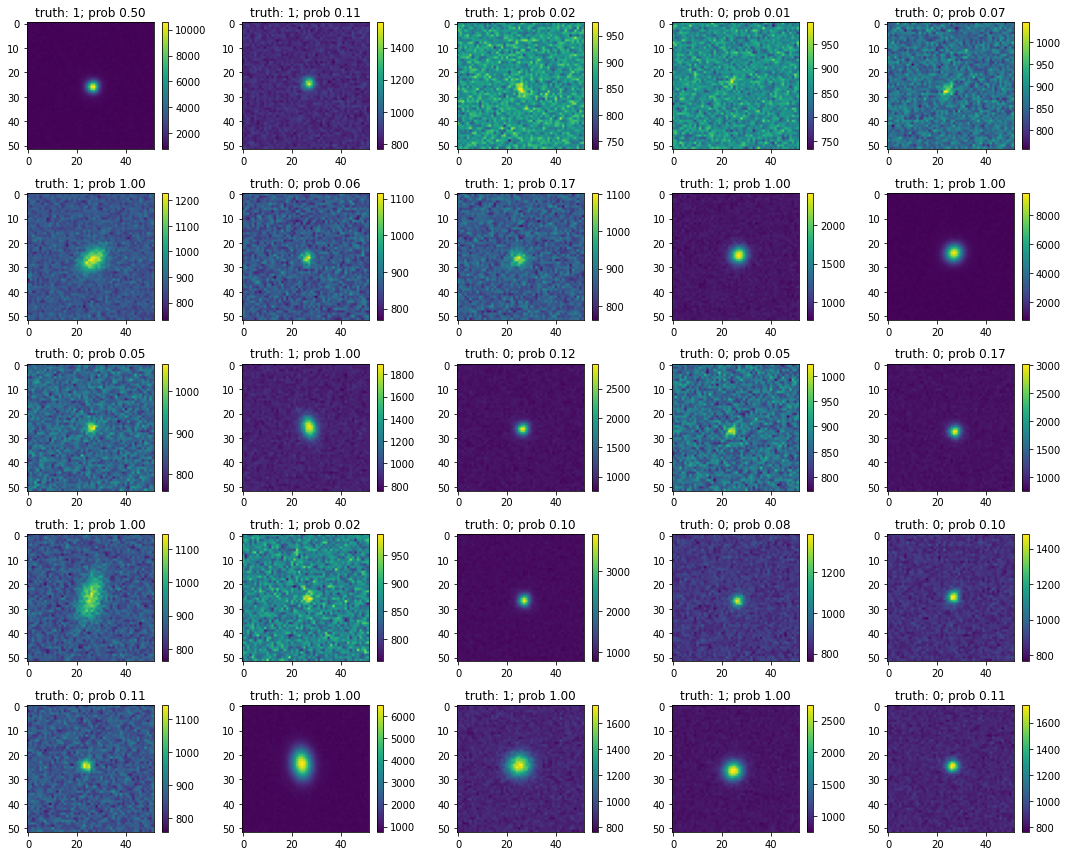

In [60]:
%matplotlib inline

fig, axes = plt.subplots(5, 5, figsize=(15,12))

for i in range(25): 
    
    this_plot = axes[i // 5, i % 5]
    
    # plot image
    im = this_plot.imshow(batch['images'][i, 0].cpu())
    fig.colorbar(im, ax = this_plot)
    
    # whether truth is galaxy 
    this_plot.set_title('truth: {:.0f}; prob {:.2f}'.format(true_gal_bool[i], 
                                                   prob_galaxy[i]))
    
    
fig.tight_layout()

# Plot only the ones we got wrong

In [68]:
# how many did we get wrong?
(est_gal_bool == true_gal_bool).float().mean()

tensor(0.8281)

In [69]:
# of true galaxies how many did we estimate as stars?
(est_gal_bool != true_gal_bool)[true_gal_bool == 1].float().mean()

tensor(0.3359)

In [70]:
# of true stars how many did we estimate as galaxies?
(est_gal_bool != true_gal_bool)[true_gal_bool == 0].float().mean()

tensor(0.)

In [66]:
which_wrong = torch.where(est_gal_bool != true_gal_bool)[0]

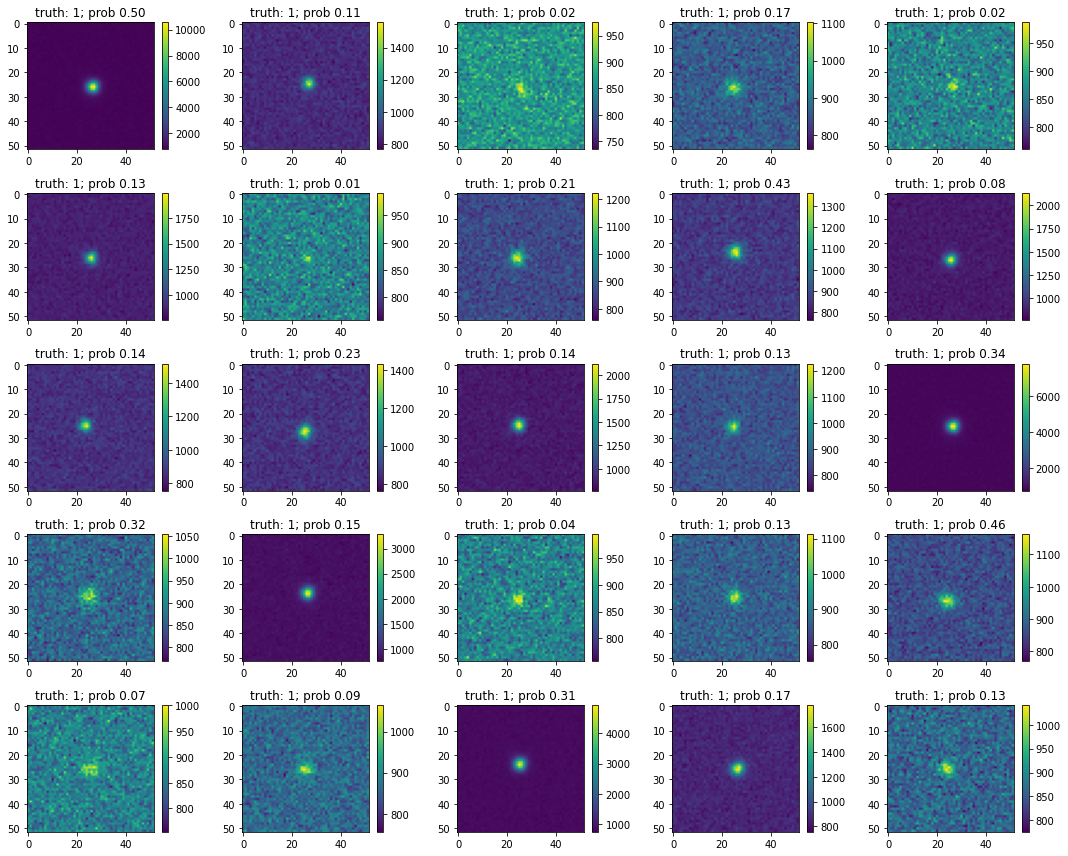

In [67]:
%matplotlib inline

fig, axes = plt.subplots(5, 5, figsize=(15,12))

for i in range(25): 
        
    this_plot = axes[i // 5, i % 5]
    
    # plot image
    indx = which_wrong[i]
    im = this_plot.imshow(batch['images'][indx, 0].cpu())
    fig.colorbar(im, ax = this_plot)
    
    # whether truth is galaxy 
    this_plot.set_title('truth: {:.0f}; prob {:.2f}'.format(true_gal_bool[indx], 
                                                            prob_galaxy[indx]))
    
    
fig.tight_layout()